In [31]:
import pickle

f = open('X.pckl', 'rb')
X = pickle.load(f)
f.close()

f2 = open('Y.pckl', 'rb')
Y = pickle.load(f2)
f2.close()

In [35]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf 
import tensorflow.contrib.slim as slim

imputer = preprocessing.Imputer()
transformed_X = imputer.fit_transform(X)
X_scaled = preprocessing.scale(transformed_X)
Y_reshape = np.reshape(Y,(len(Y),1))

test_sizes = [519/719,419/719,319/719,219/719,119/719]
NTrials = 50
LinScores = np.zeros((np.size(test_sizes),NTrials))
SVMScores = np.zeros((np.size(test_sizes),NTrials))
NNScores = np.zeros((np.size(test_sizes),NTrials))

for i in range(0,np.size(test_sizes)):
    for j in range(0,NTrials):

        X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=test_sizes[i], random_state=j)
        
        # Linear Regression
        reg = linear_model.LinearRegression()
        reg.fit(X_train,Y_train)
        YLin = reg.predict(X_test)    
        LinScores[i,j] = metrics.r2_score(Y_test,YLin)
        
        # Support Vector Machine
        clf = svm.SVR()
        clf.fit(X_train,Y_train)
        YSVM = clf.predict(X_test)
        SVMScores[i,j] = metrics.r2_score(Y_test,YSVM)
        
        # Neural Network
        Y_train = np.reshape(Y_train,(len(Y_train),1))
        Y_test = np.reshape(Y_test,(len(Y_test),1))
        
        sess = tf.Session()

        x = tf.placeholder(dtype = tf.float32, shape = [None, np.shape(X)[1]])
        y = tf.placeholder(dtype = tf.float32, shape = [None,1])

        net = slim.stack(x, slim.fully_connected, [32])
        net = slim.fully_connected(net, 1)

        loss_op = tf.reduce_mean(tf.losses.mean_squared_error(y,net))
        optimizer =tf.train.GradientDescentOptimizer(0.01)
        train_op = optimizer.minimize(loss_op)

        sess.run(tf.global_variables_initializer())

        for k in range(1000):
            sess.run(train_op, feed_dict={x: X_train, y: Y_train})

        YNN = net.eval(feed_dict={x: X_test}, session=sess)
        NNScores[i,j] = metrics.r2_score(Y_test,YNN)
        sess.close()
        tf.reset_default_graph()

In [36]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

LinScoresMean = np.mean(LinScores, axis=1)
SVMScoresMean = np.mean(SVMScores, axis=1)
NNScoresMean = np.mean(NNScores, axis=1)

LinLearned = LinScores[-1,:]
SVMLearned = SVMScores[-1,:]
NNLearned = NNScores[-1,:]
FValue, PValue = stats.f_oneway(LinLearned, SVMLearned, NNLearned)
print(PValue)

LinLabels = np.repeat(np.array('Lin'), len(LinLearned))
SVMLabels = np.repeat(np.array('SVM'), len(SVMLearned))
NNLabels = np.repeat(np.array('NN'), len(NNLearned))

DataLearned = np.hstack([LinLearned,SVMLearned,NNLearned])
LabelsLearned = np.hstack([LinLabels,SVMLabels,NNLabels])

mc = MultiComparison(DataLearned,LabelsLearned)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

1.2157416930623574e-07
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 Lin     NN    0.0615   0.037   0.086   True 
 Lin    SVM    0.0342   0.0097  0.0587  True 
  NN    SVM   -0.0273  -0.0518 -0.0028  True 
---------------------------------------------
['Lin' 'NN' 'SVM']


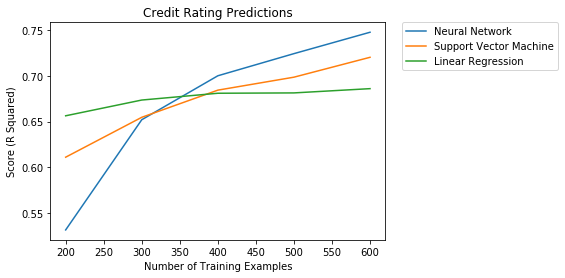

In [45]:
import matplotlib.pyplot as plt
TrainExam = [200,300,400,500,600]
plt.plot(TrainExam,NNScoresMean,label="Neural Network")
plt.plot(TrainExam,SVMScoresMean,label="Support Vector Machine")
plt.plot(TrainExam,LinScoresMean,label="Linear Regression")
plt.ylabel('Score (R Squared)')
plt.xlabel('Number of Training Examples')
plt.title('Credit Rating Predictions')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()